In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('pd_speech_features.csv',header=1)

In [4]:
X =df.drop(['class','id'],axis = 1)
y = df['class']

In [5]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X, y)


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
  X_train= X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test =y.loc[test_index]

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X_smote, y_smote):
  X_sm= X_smote.loc[train_index]
  y_sm = y_smote.loc[train_index]
  X_test_sm = X_smote.loc[test_index]
  y_test_sm =y_smote.loc[test_index]

In [8]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_sm_mms = pd.DataFrame(mms.fit_transform(X_sm),columns = X_train.columns)
X_test_mms_sm = pd.DataFrame(mms.transform(X_test_sm),columns = X_test.columns)

In [9]:
mms2=MinMaxScaler()
X_mms = pd.DataFrame(mms2.fit_transform(X_train),columns = X_train.columns)
X_test_mms = pd.DataFrame(mms2.transform(X_test),columns = X_test.columns)

In [10]:
import tensorflow as tf
from tensorflow import keras


In [11]:
input = keras.layers.Input(shape = (753,))


In [12]:
def encoder(input):
    den1 = keras.layers.Dense(512, activation='tanh')(input)
    bn1 = keras.layers.BatchNormalization()(den1)
    den2 = keras.layers.Dense(256,activation = 'tanh')(bn1)
    bn2=keras.layers.BatchNormalization()(den2)
    den3 = keras.layers.Dense(128,activation = 'tanh')(bn2)
    bn3 = keras.layers.BatchNormalization()(den3)
    return bn3

In [13]:
def decoder(bn3):    
  den4=keras.layers.Dense(256,activation = 'tanh')(bn3)
  bn4=keras.layers.BatchNormalization()(den4)
  den5=keras.layers.Dense(512,activation = 'tanh')(bn4)
  bn5=keras.layers.BatchNormalization()(den5)
  den6=keras.layers.Dense(753,activation ='linear')(bn5)
  return den6

In [14]:
autoencoder = keras.models.Model(input, decoder(encoder(input)))


In [15]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

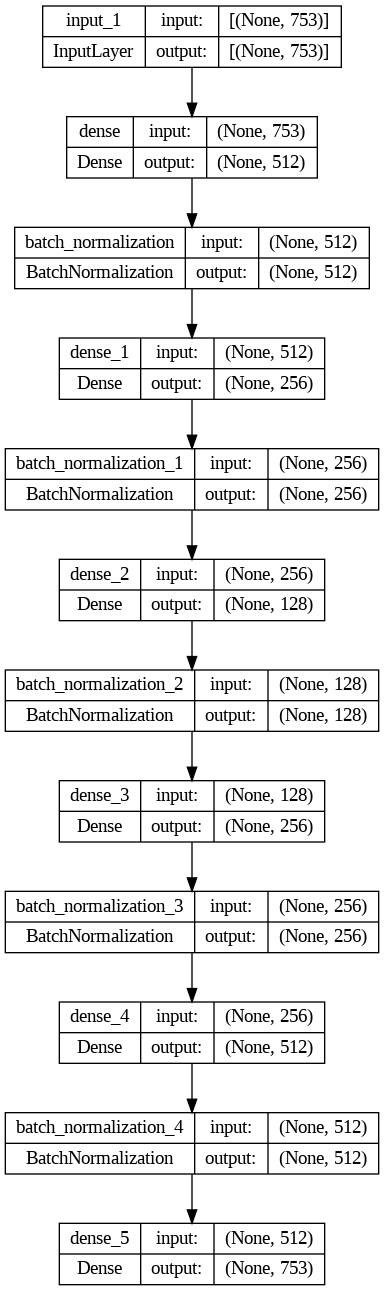

In [16]:
tf.keras.utils.plot_model(autoencoder, 'autoencoder_no_compress.png', show_shapes=True)

In [17]:
autoencoder_train = autoencoder.fit(X_sm_mms,X_sm_mms, batch_size=16,epochs=200,validation_data=(X_test_mms_sm,X_test_mms_sm))


Epoch 1/200
50/50 [==============================] - 5s 11ms/step - loss: 0.6611 - val_loss: 0.2529
Epoch 2/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2808 - val_loss: 0.2271
Epoch 3/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2188 - val_loss: 0.2025
Epoch 4/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1979 - val_loss: 0.1867
Epoch 5/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1807 - val_loss: 0.1708
Epoch 6/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1643 - val_loss: 0.1525
Epoch 7/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1432 - val_loss: 0.1298
Epoch 8/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1193 - val_loss: 0.1036
Epoch 9/200
50/50 [==============================] - 0s 6ms/step - loss: 0.0923 - val_loss: 0.0765
Epoch 10/200
50/50 [==============================] - 0s 6ms/step - loss: 0.0660 - val_loss: 0.0530
Epoch 11

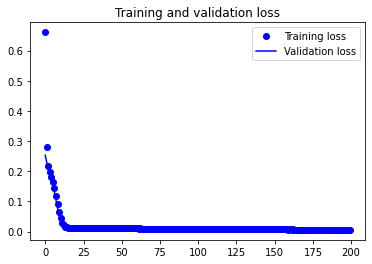

In [18]:
import matplotlib.pyplot as plt
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
encode = keras.models.Model(inputs=input, outputs=encoder(input))


In [20]:
for layers in encode.layers :
    layers.trainable = False

In [21]:
input1 = encode.output
dn = keras.layers.Dense(40, activation='tanh')(input1)
b=keras.layers.BatchNormalization()(dn)
dn1 = keras.layers.Dense(20, activation='tanh')(b)
b1=keras.layers.BatchNormalization()(dn1)

out = keras.layers.Dense(1, activation='sigmoid')(b1)


In [22]:
full_model = keras.models.Model(encode.input,out)

In [23]:
full_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 753)]             0         
                                                                 
 dense_6 (Dense)             (None, 512)               386048    
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 128)               3289

In [24]:
from keras import backend as K
def f1_m(y_true, y_pred):
    precision = tf.keras.metrics.Precision(y_true, y_pred)
    recall = tf.keras.metrics.Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [25]:
full_model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [26]:
classify_train = full_model.fit(X_sm_mms,y_sm, batch_size=16,epochs=200,validation_data=(X_test_mms_sm,y_test_sm))


Epoch 1/200
50/50 [==============================] - 3s 14ms/step - loss: 0.9089 - accuracy: 0.4626 - precision: 0.4629 - recall: 0.4582 - val_loss: 0.7920 - val_accuracy: 0.5015 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
50/50 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.6223 - precision: 0.6343 - recall: 0.5797 - val_loss: 0.7318 - val_accuracy: 0.5162 - val_precision: 1.0000 - val_recall: 0.0296
Epoch 3/200
50/50 [==============================] - 0s 6ms/step - loss: 0.5993 - accuracy: 0.6844 - precision: 0.6973 - recall: 0.6532 - val_loss: 0.6654 - val_accuracy: 0.5782 - val_precision: 0.9643 - val_recall: 0.1598
Epoch 4/200
50/50 [==============================] - 0s 6ms/step - loss: 0.5359 - accuracy: 0.7212 - precision: 0.7333 - recall: 0.6962 - val_loss: 0.6011 - val_accuracy: 0.6401 - val_precision: 0.9434 - val_recall: 0.2959
Epoch 5/200
50/50 [==============================] - 0s 6ms/step - loss: 0.4993 - accuracy: 0.7351 

In [27]:
for layers in encode.layers :
    layers.trainable = True

In [28]:
full_model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [29]:
full_model.fit(X_sm_mms,y_sm, batch_size=16,epochs=200,validation_data=(X_test_mms_sm,y_test_sm))

Epoch 1/200
50/50 [==============================] - 2s 16ms/step - loss: 0.3665 - accuracy: 0.8542 - precision_1: 0.8518 - recall_1: 0.8582 - val_loss: 0.3661 - val_accuracy: 0.8230 - val_precision_1: 0.9823 - val_recall_1: 0.6568
Epoch 2/200
50/50 [==============================] - 0s 8ms/step - loss: 0.1699 - accuracy: 0.9341 - precision_1: 0.9409 - recall_1: 0.9266 - val_loss: 0.3325 - val_accuracy: 0.8466 - val_precision_1: 0.9756 - val_recall_1: 0.7101
Epoch 3/200
50/50 [==============================] - 0s 7ms/step - loss: 0.1368 - accuracy: 0.9531 - precision_1: 0.9566 - recall_1: 0.9494 - val_loss: 0.5463 - val_accuracy: 0.7522 - val_precision_1: 1.0000 - val_recall_1: 0.5030
Epoch 4/200
50/50 [==============================] - 0s 7ms/step - loss: 0.1552 - accuracy: 0.9354 - precision_1: 0.9410 - recall_1: 0.9291 - val_loss: 0.9300 - val_accuracy: 0.6932 - val_precision_1: 1.0000 - val_recall_1: 0.3846
Epoch 5/200
50/50 [==============================] - 0s 7ms/step - loss: 0.

In [30]:
y_predicted = full_model.predict(X_test_mms)

8/8 [==============================] - 0s 2ms/step


In [31]:
from sklearn.metrics import accuracy_score

In [32]:
y_=[]
for i in y_predicted:
  if i <= 0.5:
    y_.append(0)
  else:
    y_.append(1)  

In [35]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('accuracy:')
print(accuracy_score(y_test,y_))
print('precision')
print(precision_score(y_test,y_))
print('recall')
print(recall_score(y_test,y_))
print('f')
print(f1_score(y_test,y_))

accuracy:
0.9779735682819384
precision
0.9939759036144579
recall
0.9763313609467456
f
0.9850746268656716


In [34]:
del autoencoder
del full_model

In [36]:
autoencoder = keras.models.Model(input, decoder(encoder(input)))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')


In [37]:
autoencoder_train = autoencoder.fit(X_mms,X_mms, batch_size=16,epochs=200,validation_data=(X_test_mms,X_test_mms))


Epoch 1/200
34/34 [==============================] - 2s 16ms/step - loss: 0.7620 - val_loss: 0.2258
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3943 - val_loss: 0.2212
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.2657 - val_loss: 0.2153
Epoch 4/200
34/34 [==============================] - 0s 6ms/step - loss: 0.2287 - val_loss: 0.2047
Epoch 5/200
34/34 [==============================] - 0s 7ms/step - loss: 0.2117 - val_loss: 0.1960
Epoch 6/200
34/34 [==============================] - 0s 7ms/step - loss: 0.1986 - val_loss: 0.1874
Epoch 7/200
34/34 [==============================] - 0s 7ms/step - loss: 0.1856 - val_loss: 0.1779
Epoch 8/200
34/34 [==============================] - 0s 6ms/step - loss: 0.1739 - val_loss: 0.1668
Epoch 9/200
34/34 [==============================] - 0s 6ms/step - loss: 0.1611 - val_loss: 0.1541
Epoch 10/200
34/34 [==============================] - 0s 7ms/step - loss: 0.1465 - val_loss: 0.1396
Epoch 11

In [38]:
for layers in encode.layers :
    layers.trainable = False
full_model = keras.models.Model(encode.input,out)
full_model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])    

In [39]:
full_model.fit(X_mms,y_train, batch_size=16,epochs=200,validation_data=(X_test_mms,y_test))

Epoch 1/200
34/34 [==============================] - 2s 28ms/step - loss: 0.3464 - accuracy: 0.8922 - precision_2: 0.9971 - recall_2: 0.8582 - val_loss: 0.0881 - val_accuracy: 0.9780 - val_precision_2: 0.9940 - val_recall_2: 0.9763
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3468 - accuracy: 0.8828 - precision_2: 0.9941 - recall_2: 0.8481 - val_loss: 0.0928 - val_accuracy: 0.9824 - val_precision_2: 0.9940 - val_recall_2: 0.9822
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3522 - accuracy: 0.8809 - precision_2: 1.0000 - recall_2: 0.8405 - val_loss: 0.1010 - val_accuracy: 0.9780 - val_precision_2: 0.9940 - val_recall_2: 0.9763
Epoch 4/200
34/34 [==============================] - 0s 6ms/step - loss: 0.2897 - accuracy: 0.9017 - precision_2: 0.9971 - recall_2: 0.8709 - val_loss: 0.1132 - val_accuracy: 0.9648 - val_precision_2: 0.9939 - val_recall_2: 0.9586
Epoch 5/200
34/34 [==============================] - 0s 6ms/step - loss: 0.

In [40]:
for layers in encode.layers :
    layers.trainable = True
full_model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])    

In [41]:
full_model.fit(X_mms,y_train, batch_size=16,epochs=200,validation_data=(X_test_mms,y_test))

Epoch 1/200
34/34 [==============================] - 2s 19ms/step - loss: 0.0742 - accuracy: 0.9735 - precision_3: 0.9948 - recall_3: 0.9696 - val_loss: 0.0880 - val_accuracy: 0.9824 - val_precision_3: 1.0000 - val_recall_3: 0.9763
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.9849 - precision_3: 0.9974 - recall_3: 0.9823 - val_loss: 0.0430 - val_accuracy: 0.9868 - val_precision_3: 1.0000 - val_recall_3: 0.9822
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0679 - accuracy: 0.9754 - precision_3: 0.9897 - recall_3: 0.9772 - val_loss: 0.0482 - val_accuracy: 0.9868 - val_precision_3: 1.0000 - val_recall_3: 0.9822
Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0442 - accuracy: 0.9849 - precision_3: 1.0000 - recall_3: 0.9797 - val_loss: 0.0463 - val_accuracy: 0.9868 - val_precision_3: 1.0000 - val_recall_3: 0.9822
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.

In [42]:
y_predicted = full_model.predict(X_test_mms)
y_=[]
for i in y_predicted:
  if i <= 0.5:
    y_.append(0)
  else:
    y_.append(1)  

8/8 [==============================] - 0s 2ms/step


In [43]:
print('accuracy:')
print(accuracy_score(y_test,y_))
print('precision')
print(precision_score(y_test,y_))
print('recall')
print(recall_score(y_test,y_))
print('f')
print(f1_score(y_test,y_))

accuracy:
0.9823788546255506
precision
0.9940119760479041
recall
0.9822485207100592
f
0.988095238095238


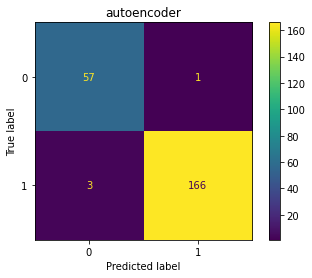

In [44]:
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test,y_)
plt.title("autoencoder")
plt.show()